In [2]:
import matplotlib.pyplot as plt
import random
import torch

torch.manual_seed(0)
random.seed(0)

# ***Assignment 1.2.5 - BBVI - Algorithm 1***

In [3]:
def generate_data(mu, tau, N):
  x = torch.linspace(-10, 10, N)
  # Insert your code here
  sigma = 1 / torch.sqrt(torch.tensor(tau))   # precision τ = 1/σ²
  torch.manual_seed(10)
  
  D = torch.normal(mu, sigma, size=(N,))

  return D


Set μ = 1, τ = 0.5 and generate a dataset with size N=100.
Plot the histogram for the generated dataset.


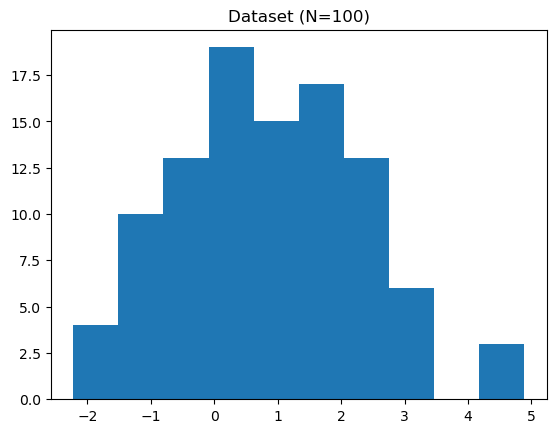

In [4]:
mu = 1
tau = 0.5

dataset = generate_data(mu, tau, 100)

# Visulaize the datasets via histograms
plt.figure()
plt.hist(dataset)
plt.title("Dataset (N=100)")

plt.show()


In [ ]:

class BlackBoxVI:
    """Black Box Variational Inference implementation."""
    
    def __init__(self, D, log_joint_distribution, variational_family_q,S=10, learning_rate=0.01):
        """
        Black Box Variational Inference implementation without any .
            Args:
                D: dataset
                log_joint_distribution: function that computes the log joint distribution
                variational_family_q: variational family q with parameters to optimize
                S: number of samples for Monte Carlo estimation
                learning_rate: learning rate for the optimizer
        """
        self.D = D
        self.log_joint_distribution = log_joint_distribution
        self.variational_family_q = variational_family_q
        self.S = S
        self.learning_rate = learning_rate

        
    def compute_elbo(self, num_samples=100):
        """Compute the Evidence Lower Bound (ELBO)
        ELBO = E_q[log p(D, z)] - E_q[log q(z)].
        Args:
            num_samples: number of samples for Monte Carlo estimation
        Returns:
            ELBO value
        """
        elbo = 0
        for _ in range(num_samples):
            z_sample = self.variational_family_q.sample()
            log_p = self.log_joint_distribution(self.D, z_sample)
            log_q = self.variational_family_q.log_prob(z_sample)
            elbo += (log_p - log_q)
        elbo = elbo / num_samples
        return elbo.item()

    def fit(self,threshold = 0.0001, max_iterations = 1000):
        """Fit the variational parameters using BBVI algorithm.
        Args:
            threshold: convergence threshold
            max_iterations: maximum number of iterations
        """
        history = {
            "elbo" : [],
            "params" : [self.variational_family_q.get_parameters()],
            "final_params" : None,
            'mu_expected': None,
            'tau_expected': None,
        }
        for t in range(1,max_iterations+1):
            gradient = torch.zeros(4)
            variational_parameters = self.variational_family_q.get_parameters()
            for s in range(self.S):
                z_s = self.variational_family_q.sample()

                #compute log(q(z[s]))
                log_q_z_s = self.variational_family_q.log_prob(z_s)
                
                # Compute log p(x, z[s])
                log_p_z_s_D = self.log_joint_distribution(self.D, z_s)
                
                # Compute the score function ∇_λ log q(z[s]; λ)
                score_function = self.variational_family_q.score_function(z_s)
                
                gradient += score_function * (log_p_z_s_D - log_q_z_s)
                
            gradient = gradient / self.S
            
            rho = self.learning_rate/t
            
            variational_parameters = variational_parameters + rho * gradient
            
            self.variational_family_q.set_parameters(variational_parameters)
            
            #we compute the elb and we check the params every 10 iterations and at the first iteration
            if t % 10 == 0 or t == 1:
                history["elbo"].append((t,self.compute_elbo(50)))
                history["params"].append(self.variational_family_q.get_parameters())
            
            # Check for convergence (you can implement a more sophisticated check)
            if (rho*gradient ).abs().max() < threshold:
                break
        history['final_params'] = self.variational_family_q.get_parameters()
        mu_N,lambda_N, alpha_N,beta_N = self.variational_family_q.get_parameters()
        history['mu_expected'] = mu_N.item()
        history['tau_expected'] = (alpha_N / beta_N).item()
        
        return history
            

**Gaussian Variational Family**

In [ ]:

class NormalGammaVariationalFamily():
    """
      Variational family for Normal-NormalGamma conjugate model.
    
        Variational distribution: q(μ, τ | λ) = q(μ | τ) q(τ)
        where:
            - μ | τ ~ Normal(μ_N, (λ_N * τ)^(-1))
            - τ ~ Gamma(α_N, β_N)
        
        Parameters: λ = [μ_N, λ_N, α_N, β_N]
    """
    def __init__(self):
        """Initialize with dimension of latent variable.""" 
        mu_N = torch.randn(1).item()
        lambda_N = torch.rand(1).item() * 2 + 0.5
        alpha_N = torch.rand(1).item() * 3 + 1.0
        beta_N = torch.rand(1).item() * 3 + 0.5
        
        self.parameters = torch.tensor([
            mu_N, torch.log(torch.tensor(lambda_N)), torch.log(torch.tensor(alpha_N)), torch.log(torch.tensor(beta_N))
        ], requires_grad=True)
        
        self.eps = 1e-6
        self.large_val = 1e20
        self.max_log_val = 80.0
        self.max_mean=1000
        
    def get_actual_parameters(self):
        mu_N = self.parameters[0]
        
        lambda_N = torch.exp(self.parameters[1].clamp(max=self.max_log_val))
        alpha_N = torch.exp(self.parameters[2].clamp(max=self.max_log_val))
        beta_N = torch.exp(self.parameters[3].clamp(max=self.max_log_val))
        
        return mu_N, lambda_N, alpha_N, beta_N

    def get_parameters(self):
        return self.parameters.clone()
    
    def set_parameters(self,new_params):
        self.parameters = new_params.clone()
    

    def sample(self):
        """Sample from the variational distribution."""
       
        mu_N, lambda_N, alpha_N, beta_N = self.get_actual_parameters()
        eps = self.eps
        large_val = self.large_val
        
        alpha_N_safe = alpha_N.clamp(min=eps)
        beta_N_safe = beta_N.clamp(min=eps)

        tau = torch.distributions.Gamma(alpha_N_safe, beta_N_safe).sample()
        
        lambda_N_safe = lambda_N.clamp(min=eps) 
        tau_safe = tau.clamp(min=eps)
        
        precision = lambda_N_safe * tau_safe
        
        safe_precision = precision.clamp(min=eps, max=large_val)
        
        sigma_mu = 1.0 / torch.sqrt(safe_precision)
        
        sigma_mu = sigma_mu.clamp(min=eps)
        
        mu_N_safe = mu_N.clamp(min=-self.max_mean, max=self.max_mean)
        
        mu = torch.distributions.Normal(mu_N_safe, sigma_mu).sample()
        
        return (mu,tau)
    
    def log_prob(self, z):
        """Compute log probability of z under the variational distribution.
            Compute log q(μ, τ | λ).
         """
        mu, tau = z
        mu_N, lambda_N, alpha_N, beta_N = self.get_actual_parameters()
        eps = self.eps
        large_val = self.large_val

        alpha_N_safe = alpha_N.clamp(min=eps)
        beta_N_safe = beta_N.clamp(min=eps)
        tau_safe = tau.clamp(min=eps)
        
        log_q_tau = torch.distributions.Gamma(alpha_N_safe, beta_N_safe).log_prob(tau_safe)
        
        lambda_N_safe = lambda_N.clamp(min=eps)
        
        precision = lambda_N_safe * tau_safe
        
        safe_precision = precision.clamp(min=eps, max=large_val)
        
        sigma_mu = 1.0 / torch.sqrt(safe_precision)
        
        sigma_mu = sigma_mu.clamp(min=eps)
        
        mu_N_safe = mu_N.clamp(min=-self.max_mean, max=self.max_mean)

        
        log_q_mu_given_tau = torch.distributions.Normal(mu_N_safe,sigma_mu).log_prob(mu)

        return log_q_tau + log_q_mu_given_tau
    
    def score_function(self,z):
        """
        Compute the score function ∇_λ log q(z; λ).
          
          z = (μ^(s), τ^(s)) is a sample from the variational distribution
          λ = [μ_N, λ_N, α_N, β_N] are the variational parameters
        """
        
        mu, tau = z
        mu_N, lambda_N, alpha_N, beta_N = self.get_actual_parameters()
        eps = self.eps
        
        lambda_N_safe = lambda_N.clamp(min=eps)
        alpha_N_safe = alpha_N.clamp(min=eps)
        beta_N_safe = beta_N.clamp(min=eps)
        tau_safe = tau.clamp(min=eps)

        # Gradient log q(μ | λ) with respect to λ
        grad_mu_wrt_mu_N = (mu - mu_N) / lambda_N_safe
        grad_mu_wrt_lambda_N = ((mu - mu_N)**2 - lambda_N) / (2*lambda_N_safe**2)
        
        # Gradient log q(τ | λ) with respect to λ
        grad_tau_wrt_alpha_N = torch.log(beta_N_safe) - torch.digamma(alpha_N_safe) + torch.log(tau_safe)
        grad_tau_wrt_beta_N = (alpha_N_safe / beta_N_safe) - tau
        
            
         # === Apply chain rule for log-parametrization ===
        
        grad_log_mu_N = grad_mu_wrt_mu_N
        
        grad_log_lambda_N = lambda_N * grad_mu_wrt_lambda_N
        
        grad_log_alpha_N = alpha_N * grad_tau_wrt_alpha_N
        
        grad_log_beta_N = beta_N * grad_tau_wrt_beta_N
        
        return torch.stack([grad_log_mu_N, grad_log_lambda_N, 
                                grad_log_alpha_N, grad_log_beta_N])


In [7]:
def log_joint_distribution(D, z):
        """Compute the log joint distribution log p(D, Z).
        Args:
            D: dataset
            Z: latent variables
        Returns:
            log p(D, Z)
        """
        # log p(D, Z) = log p(D|Z) + log p(Z)
        # Z = (mu, tau)
        
        mu, tau = z
        sigma = 1 / torch.sqrt(tau)
        
        mu_0 = 1.0
        lambda_0 = 0.1 
        a_0 = 1.0
        b_0 = 2.0  
        
        #log P(D|Z)
        log_likelihood = torch.distributions.Normal(mu, sigma).log_prob(D).sum()
        
        #log P(mu , tau) = log P(mu | tau) + log P(tau)
        
        # Log prior p(μ | τ)
        precision_mu = lambda_0 * tau
        sigma_mu = 1.0 / torch.sqrt(precision_mu)
        log_prior_mu = torch.distributions.Normal(mu_0, sigma_mu).log_prob(mu)
        
        # Log prior p(τ)
        log_prior_tau = torch.distributions.Gamma(a_0, b_0).log_prob(tau)
        
        
        return log_likelihood + log_prior_mu + log_prior_tau

## Application


Final Results:
E_q[μ] = -1.0035 (true: 1)
E_q[τ] = 0.4171 (true: 0.5)
Data mean: 0.8901
Data precision: 0.4580


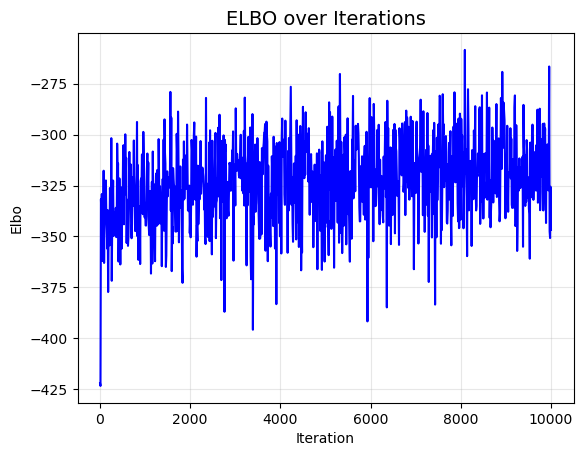

In [9]:

q = NormalGammaVariationalFamily()

bbvi = BlackBoxVI(dataset,log_joint_distribution=log_joint_distribution,variational_family_q=q,learning_rate=2e-4)
results = bbvi.fit(threshold=0.00000001,max_iterations=10**4)
"""
results = {
            "elbo" : [],
            "params" : [],
            "final_params" : float,
            'mu_expected': float,
            'tau_expected': float,
        }
"""
print(f"\n{'='*60}")
print(f"Final Results:")
print(f"E_q[μ] = {results['mu_expected']:.4f} (true: {mu})")
print(f"E_q[τ] = {results['tau_expected']:.4f} (true: {tau})")
print(f"Data mean: {dataset.mean():.4f}")
print(f"Data precision: {1.0/dataset.var():.4f}")
print(f"{'='*60}")
### Plot of the ELBO
iterations, elbos = zip(*results["elbo"])
plt.plot(iterations,elbos,'b-')
plt.xlabel("Iteration")
plt.ylabel("Elbo")
plt.title('ELBO over Iterations', fontsize=14)
plt.grid(alpha=0.3)


